## Kernel to load: vax_inc_arcgis 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pycountry
from matplotlib.colors import Normalize
from descartes import PolygonPatch
import pickle
import re
import matplotlib.patches as mpatches
import arcpy
from textwrap import wrap
from arcgis.features import GeoAccessor
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
full_df=pd.read_csv('Supplementary Spreadsheet- Vaccination Coverage Estimates.csv')

In [4]:
df_cattle=full_df[full_df['Animal']=='Cattle']
df_poultry=full_df[full_df['Animal']=='Poultry']
df_swine=full_df[full_df['Animal']=='Pigs']

In [5]:
df_pop_cattle=pd.read_csv(os.path.join(source_data_path, 'cattle','cattle_pop_2024.csv'))
df_pop_cattle=df_pop_cattle[df_pop_cattle['Year'].isin([2020])]
df_pop_cattle2=pd.read_csv(os.path.join(source_data_path, 'cattle','cattle_pop_2024.csv')).sort_values('Year').drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_cattle=df_pop_cattle.merge(df_pop_cattle2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_cattle.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_cattle['scale']=df_pop_cattle['latest pop']/df_pop_cattle['2020 pop']
#
df_pop_poultry=pd.read_csv(os.path.join(source_data_path, 'poultry','poultry_pop_2024.csv'))
df_pop_poultry = (
    df_pop_poultry.groupby(['Area Code (M49)', 'Year Code'], as_index=False)
    .agg({
        'Domain Code': 'first',
        'Domain': 'first',
        'Area Code (M49)': 'first',
        'Area': 'first',
        'Element Code': 'first',
        'Element': 'first',
        'Item Code (CPC)': 'first',
        'Year Code': 'first',
        'Year': 'first',
        'Unit': 'first',
        'Value': 'sum',  
        'Flag': 'first',
        'Flag Description': 'first',
        'Note': 'first'
    })
)
df_pop_poultry['Item'] = 'Poultry'
df_pop_poultry=df_pop_poultry[df_pop_poultry['Year'].isin([2020])]
df_pop_poultry2=pd.read_csv(os.path.join(source_data_path, 'poultry','poultry_pop_2024.csv')).sort_values('Year')
df_pop_poultry2 = (
    df_pop_poultry2.groupby(['Area Code (M49)', 'Year Code'], as_index=False)
    .agg({
        'Domain Code': 'first',
        'Domain': 'first',
        'Area Code (M49)': 'first',
        'Area': 'first',
        'Element Code': 'first',
        'Element': 'first',
        'Item Code (CPC)': 'first',
        'Year Code': 'first',
        'Year': 'first',
        'Unit': 'first',
        'Value': 'sum', 
        'Flag': 'first',
        'Flag Description': 'first',
        'Note': 'first'
    })
)
df_pop_poultry2=df_pop_poultry2.drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_poultry=df_pop_poultry.merge(df_pop_poultry2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_poultry.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_poultry['scale']=df_pop_poultry['latest pop']/df_pop_poultry['2020 pop']

df_pop_swine=pd.read_csv(os.path.join(source_data_path, 'swine','swine_pop_2024.csv'))
df_pop_swine=df_pop_swine[df_pop_swine['Year'].isin([2020])]
df_pop_swine2=pd.read_csv(os.path.join(source_data_path, 'swine','swine_pop_2024.csv')).sort_values('Year').drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_swine=df_pop_swine.merge(df_pop_swine2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_swine.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_swine['scale']=df_pop_swine['latest pop']/df_pop_swine['2020 pop']


#Taking care of edge cases (for example, if older population size was estimted at '0', or some other issue, despite having vaccination data, and gridded livestock data for the animal (technical issue with one of the data sources, I believe only 1 instance, with Iran Swine, where past and present is listed at 0 ))
df_pop_swine['scale'] = df_pop_swine['scale'].replace(np.nan, 1)
df_pop_poultry['scale'] = df_pop_poultry['scale'].replace(np.nan, 1)
df_pop_cattle['scale'] = df_pop_cattle['scale'].replace(np.nan, 1)



In [6]:
pop_countries_cattle = df_pop_cattle['Area']
pop_countries_poultry = df_pop_poultry['Area']
pop_countries_swine = df_pop_swine['Area']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    countries['USA']='USA'
    countries['UK']='GBR'
    countries['Taiwan']='TWN'
    countries['South Korea']='KOR'
    countries['Czech Republic']='CZE'
    countries['Brunei']='BRN'
    countries['Russia']='RUS'
    countries['IrAAan']='IRN'
    countries['United States of America']='USA'
    countries['Venezuela']='VEN'
    countries['China (Hong Kong SAR)']='HKG'
    countries["Cote d'Ivoire"]='CIV'
    countries['DR Congo']='COD'
    countries['Guinea Bissau']='GNB'
    countries['Lao PDR']='LAO'
    countries['Micronesia (Federated States of)']='FSM'
    countries['North Korea']='PRK'
    countries['Occupied Palestinian Territory']='PSE'
    countries['Swaziland']='SWZ'
    countries['Tanzania']='TZA'
    countries['Bolivia']='BOL'
    countries['Macedonia (TFYR)']='MKD'
    countries['Moldova']='MDA'
    countries['Bolivia (Plurinational State of)']='BOL'
    countries['China, Hong Kong SAR']='HKG'
    countries['China, Taiwan Province of']='TWN'
    countries['China, mainland']='CHN'
    countries['Czechoslovakia']='CSK'
    countries["Democratic People's Republic of Korea"]='PRK'
    countries['Democratic Republic of the Congo']='COD'
    countries['French Guyana']='GUF'
    countries['Micronesia']='FSM'
    countries['Palestine']='PSE'
    countries['Polynesia']='PYF'
    countries['Republic of Korea']='KOR'
    countries['Serbia and Montenegro']='SCG'
    countries['Sudan (former)']='SDN'
    countries['Türkiye']='TUR'
    countries['USSR']='SUN'
    countries['Iran (Islamic Republic of)']='IRN'
    countries['Republic of Moldova']='MDA'
    countries['United Kingdom of Great Britain and Northern Ireland']='GBR'
    countries['United Republic of Tanzania']='TZA'
    countries['Venezuela (Bolivarian Republic of)']='VEN'
    countries['Yugoslav SFR']='YUG'
    countries['Ethiopia PDR']='ETH'
    countries['Central African (Rep.)']='CAF'
    countries["China (People's Rep. of)"]='CHN'
    countries['Chinese Taipei']='TWN'
    countries['Congo (Dem. Rep. of the)']='COD'
    countries['Congo (Rep. of the)']='COG'
    countries["Cote D'Ivoire"]='CIV'
    countries['Dominican (Rep.)']='DOM'
    countries["Korea (Dem People's Rep. of)"]='PRK'
    countries['Korea (Rep. of)']='KOR'
    countries['Laos']='LAO'
    countries['South Sudan (Rep. of)']='SSD'
    countries['Syria']='SYR'
    countries['St. Vincent and the Grenadines']='VCT'
    countries['Vietnam']='VNM'
    countries['Reunion']='REU'
    countries['Guadaloupe']='GLP'
    countries['Netherlands (Kingdom of the)']='NLD'
    countries['China, Macao SAR']='MAC'
    countries['Türkiye (Rep. of)']='TUR'
    countries['Belgium-Luxembourg']="BLX"
    countries['Kosovo']='XKX'


codes_pop_cattle = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_cattle]

iso3s_pop_cattle=[]

for i in pop_countries_cattle:
    try:
        iso3s_pop_cattle+=[countries[i]]
    except:
        iso3s_pop_cattle+=[None]
        
df_pop_cattle['ISO3']=iso3s_pop_cattle

codes_pop_poultry = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_poultry]

iso3s_pop_poultry=[]

for i in pop_countries_poultry:
    try:
        iso3s_pop_poultry+=[countries[i]]
    except:
        iso3s_pop_poultry+=[None]
        
df_pop_poultry['ISO3']=iso3s_pop_poultry

codes_pop_swine = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_swine]

iso3s_pop_swine=[]

for i in pop_countries_swine:
    try:
        iso3s_pop_swine+=[countries[i]]
    except:
        iso3s_pop_swine+=[None]
        
df_pop_swine['ISO3']=iso3s_pop_swine

print(np.unique(codes_pop_cattle+iso3s_pop_poultry+iso3s_pop_swine))  

['AFG' 'ALB' 'ARE' 'ARG' 'ARM' 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLX' 'BLZ' 'BOL' 'BRA' 'BRB'
 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG'
 'COK' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK'
 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'FRO'
 'FSM' 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GLP' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD'
 'GTM' 'GUF' 'GUY' 'HKG' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL' 'IRN'
 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR'
 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LKA' 'LSO' 'LTU' 'LUX'
 'LVA' 'MAC' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE' 'MNG'
 'MOZ' 'MRT' 'MTQ' 'MUS' 'MWI' 'MYS' 'NAM' 'NCL' 'NER' 'NGA' 'NIC' 'NIU'
 'NLD' 'NOR' 'NPL' 'NRU' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'PNG' 'POL'
 'PRI' 'PRK' 'PRT' 'PRY' 'PSE' 'PYF' 'QAT' 'REU' 'ROU' 'RUS' 'RWA' 'SAU'
 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'SOM' 'SRB' 'S

In [7]:
df_pop_cattle=df_pop_cattle[['scale','ISO3']]

df_pop_poultry=df_pop_poultry[['scale','ISO3']]

df_pop_swine=df_pop_swine[['scale','ISO3']]


In [8]:
df_coverage_cattle=pd.merge(df_cattle, df_pop_cattle, on=['ISO3'], how='left')
df_coverage_poultry=pd.merge(df_poultry, df_pop_poultry, on=['ISO3'], how='left')
df_coverage_swine=pd.merge(df_swine, df_pop_swine, on=['ISO3'], how='left')

In [9]:
df_animals=pd.concat([df_coverage_cattle,df_coverage_poultry,df_coverage_swine])

In [10]:
np.unique(df_coverage_poultry[(df_coverage_poultry['Disease']=='Newcastle disease')]['Source'])

array(['Country-specific survey',
       'Department of Agriculture Animal and Plant Health Inspection Service report',
       'Imputed',
       'PVS Gap Analysis of the Veterinary Services (VS) of the Republic of Vanuatu',
       'Solomon Islands Smallholder Agriculture Study', 'USDA Report',
       'USDA Survey', 'WAHIS administrative division reports',
       'WAHIS administrative division reports (includes linear interpolation)',
       'WAHIS country-level report; FAOSTAT',
       'WAHIS country-level report; FAOSTAT (linear interpolation between years)',
       'WOAH country-specific report'], dtype=object)

In [11]:
df_animals=df_animals.sort_values('scale').drop_duplicates(['ISO3','Disease','Animal','Year'],keep='last')

In [12]:
df_animals[df_animals.duplicated(['ISO3','Disease','Animal','Year'], keep=False)]
#Should output no records

,Country,ISO3,Animal,Year,Disease,Vaccination Coverage (%),Source,Vaccination Coverage (%) Lower,Vaccination Coverage (%) Upper,Year Data,Official Vaccination Measure,Year Official Vaccination Measure,scale


In [13]:
df_animals['scale'].fillna(1, inplace=True)

In [14]:
df_animals.drop(columns=['Vaccination Coverage (%) Lower','Vaccination Coverage (%) Upper','Official Vaccination Measure',
                     'Year Official Vaccination Measure','Year Data'],inplace=True)

In [15]:
df_animals=df_animals[df_animals['Year']==2024]

In [16]:
df_approved_prohibited=pd.read_csv('Supplementary Spreadsheet- Vaccination Coverage Estimates.csv')
df_approved_prohibited=df_approved_prohibited[df_approved_prohibited['Official Vaccination Measure'].notnull()].loc[:,['Country','ISO3','Animal','Year','Disease','Official Vaccination Measure','Year Official Vaccination Measure']]
df_approved_prohibited=df_approved_prohibited[df_approved_prohibited['Year']==2024]

In [17]:
SHAPEFILE = os.path.join(source_data_path,'World_Countries_Map/World_Countries__Generalized_.shp')

geo_df = gpd.read_file(SHAPEFILE)
geo_df=geo_df.loc[:,['COUNTRY', 'ISO', 'geometry']]
geo_df.head(3)

,COUNTRY,ISO,geometry
0,Afghanistan,AF,"POLYGON ((61.27655 35.60725, 61.29638 35.62854..."
1,Albania,AL,"POLYGON ((19.57083 41.68527, 19.58195 41.69569..."
2,Algeria,DZ,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ..."


<AxesSubplot:>

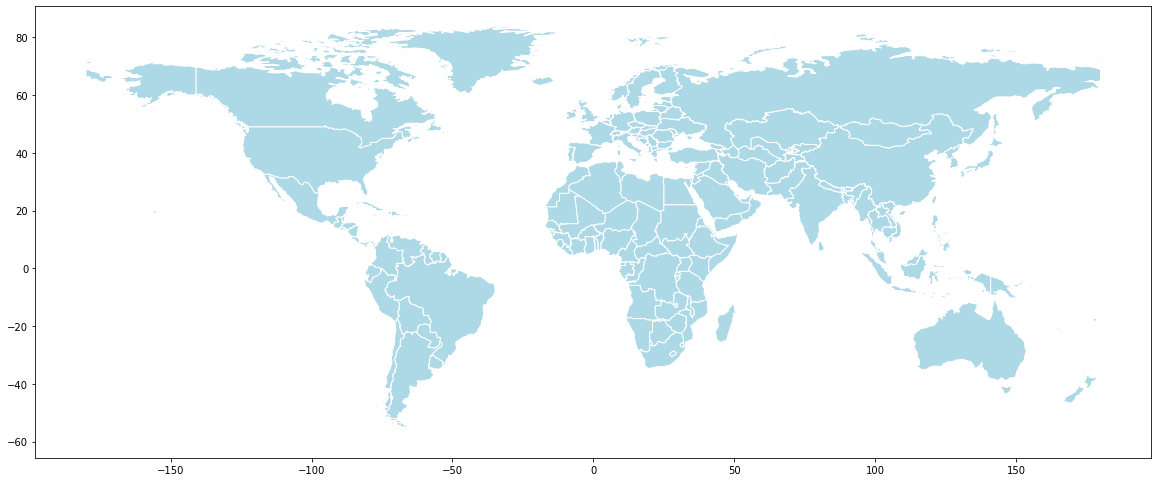

In [18]:
# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['COUNTRY'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [19]:
pop_countries_geo = geo_df['ISO']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


codes_pop_geo = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_geo]

iso3s_pop_geo=[]

for i in pop_countries_geo:
    try:
        iso3s_pop_geo+=[countries[i]]
    except:
        iso3s_pop_geo+=[None]
        
geo_df['ISO3']=iso3s_pop_geo


print(np.unique(codes_pop_geo))  # prints ['AS', 'CA', 'FR']

['ABW' 'AFG' 'AGO' 'AIA' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ASM' 'ATF' 'ATG'
 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BES' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLM' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BVT' 'BWA'
 'CAF' 'CAN' 'CCK' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COK' 'COL'
 'COM' 'CPV' 'CRI' 'CUB' 'CUW' 'CXR' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FLK'
 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GIN' 'GLP' 'GMB'
 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUF' 'GUM' 'GUY' 'HMD' 'HND' 'HRV'
 'HTI' 'HUN' 'IDN' 'IMN' 'IND' 'IOT' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT'
 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAF'
 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEX' 'MHL' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE'
 'MNG' 'MNP' 'MOZ' 'MRT' 'MSR' 'MTQ' 'MUS' 'MWI' 'MYS' 'MYT' 'NAM' 'NCL'
 'NER' 'NFK' 'NGA' 'NIC' 'NIU' 'NLD' 'NOR' 'NPL' 'N

In [20]:
def plotCountryPatch( axes, country_name, fcolor, merged_df):
    # plot a country on the provided axes
    nami = merged_df[merged_df.ISO3 == country_name]
    namigm = nami.__geo_interface__['features'] 
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="lightgrey", alpha=0.5, zorder=2,linewidth=0.2, hatch='/' ))

In [21]:
with open(os.path.join(source_data_path,'vaccines_sorted_by_use.pickle'),'rb') as handle:
    _,_,_,top_vaccines=pickle.load(handle)

In [22]:
iso3_to_country=dict()
for country in pycountry.countries:
    iso3_to_country[country.alpha_3] = country.name

for iso3 in geo_df['ISO3']:
    if iso3 not in iso3_to_country.keys():
        print(iso3)

In [23]:
arcpy.env.workspace=os.getcwd()
arcpy.env.overwriteOutput = True

In [24]:
top_vaccines=[(i[0],i[1],i[2]) if 'Newcast' not in i[1] else (i[0],'Newcastle disease (velogenic)',i[2]) for i in top_vaccines]

In [26]:
for animal in ['Poultry','Cattle','Swine']:
    
    # Set local variables (DENSITIES)
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","GLW4-2020.D-DA.CHK.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","GLW4-2020.D-DA.CTL.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","GLW4-2020.D-DA.PGS.tif")
        
    if animal =='Poultry':
        inRaster =os.path.join(source_data_path,"chickens_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,"chickens_dataverse","number_chickens.tif")
    elif animal == 'Cattle':
        inRaster =os.path.join(source_data_path,"cattle_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,'cattle_dataverse','number_cattle.tif')
    else:
        inRaster =os.path.join(source_data_path,"swine_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,'swine_dataverse','number_pigs.tif')

    
    
 # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save(save_to)

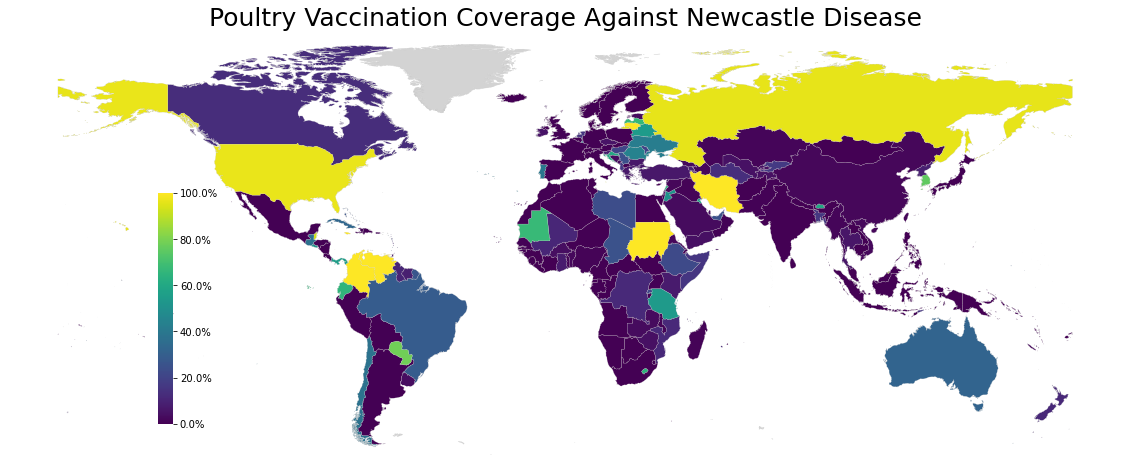

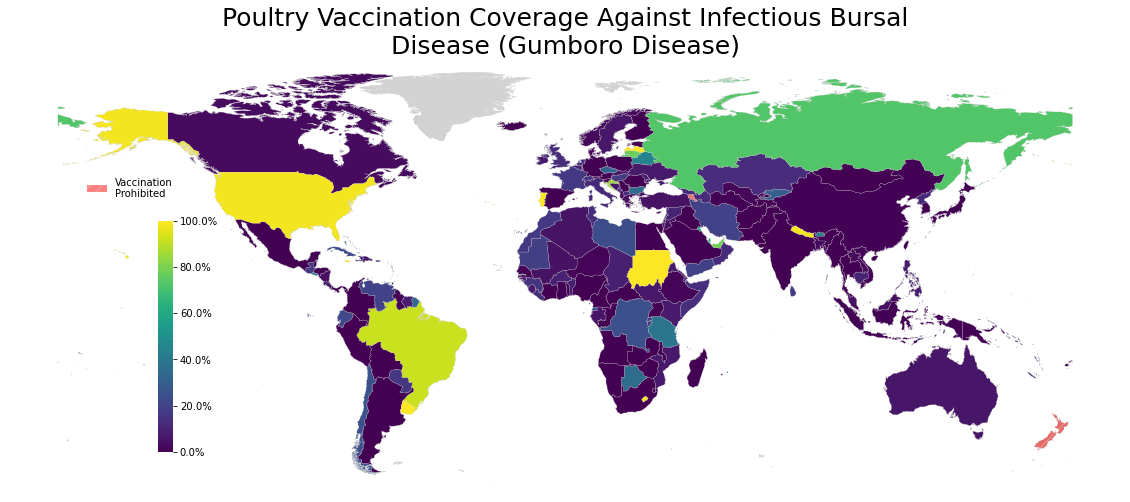

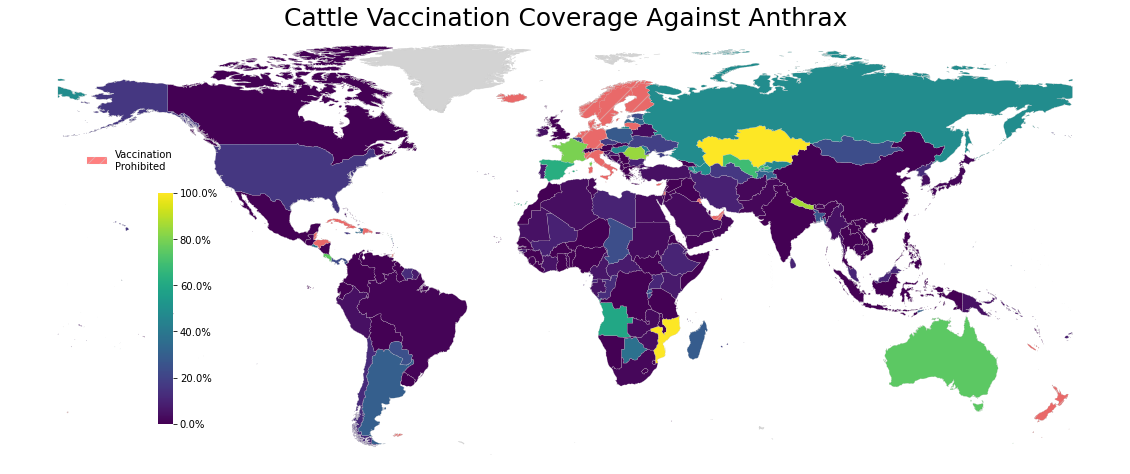

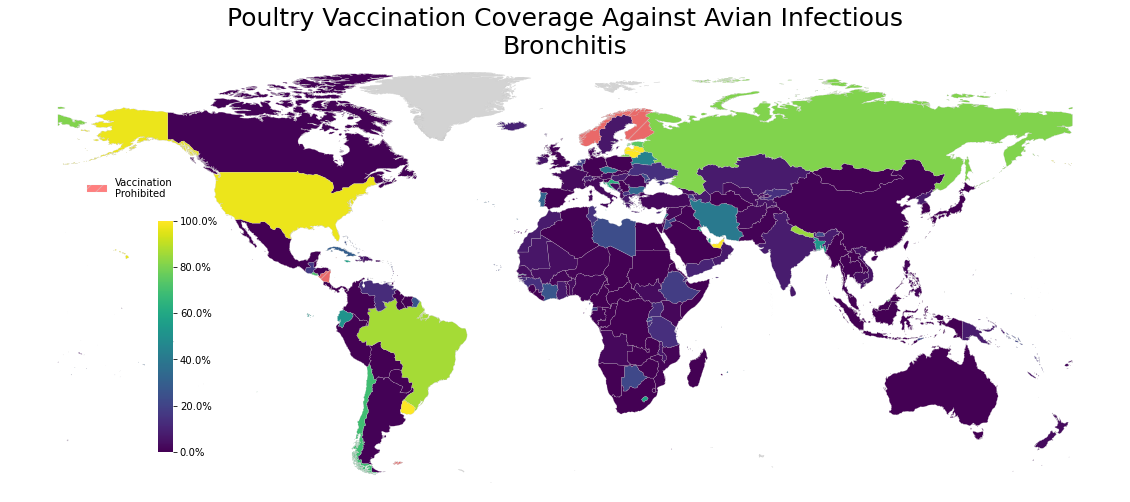

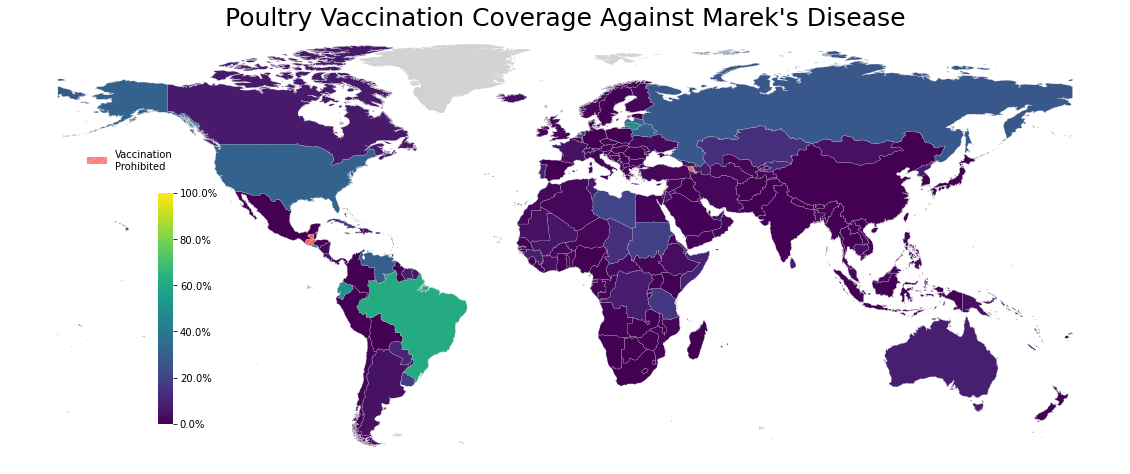

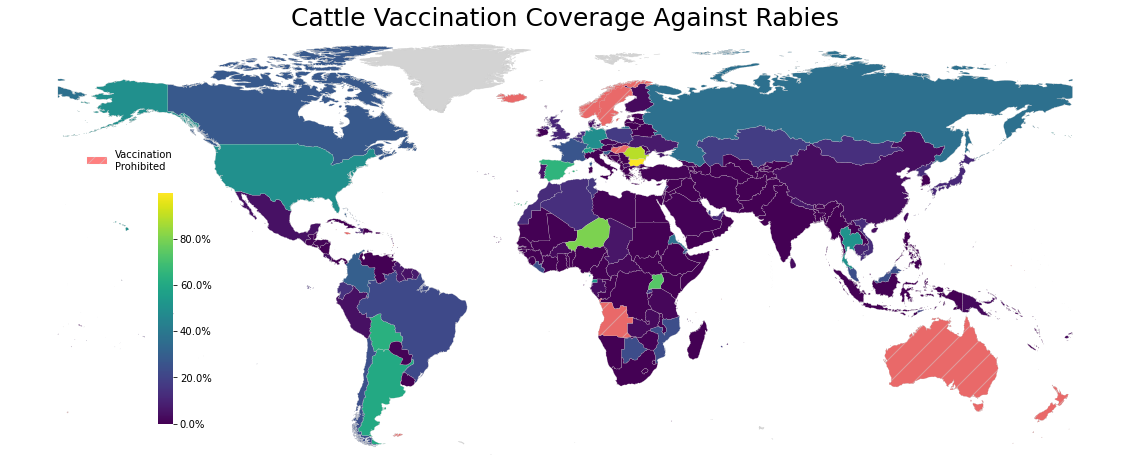

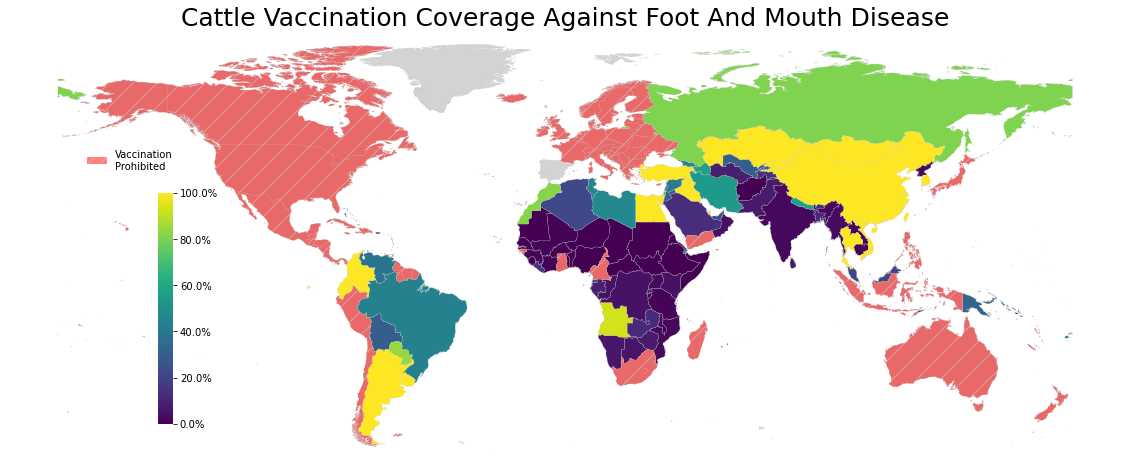

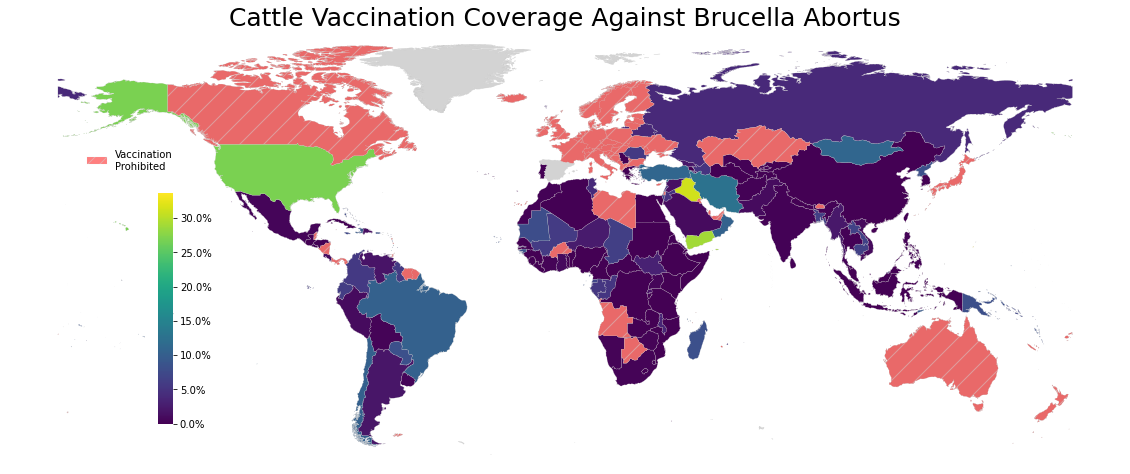

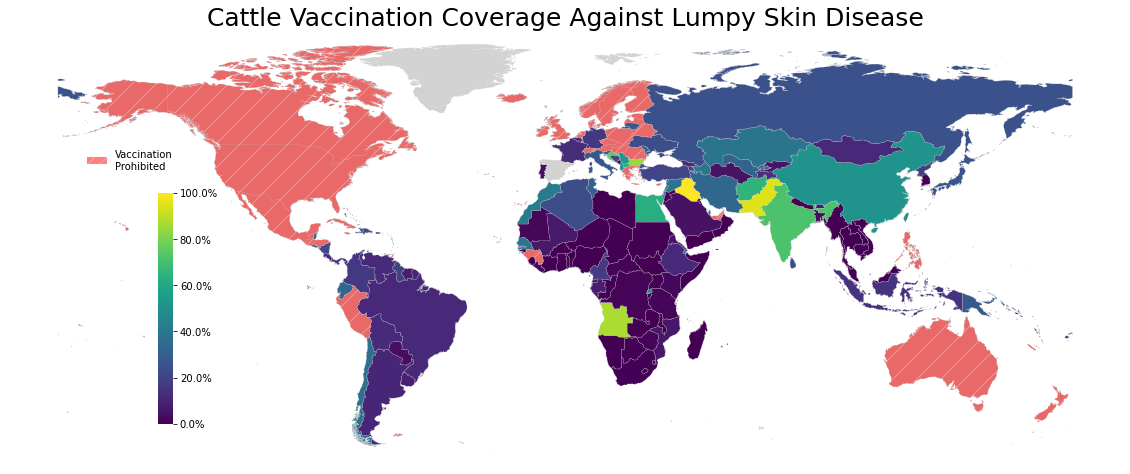

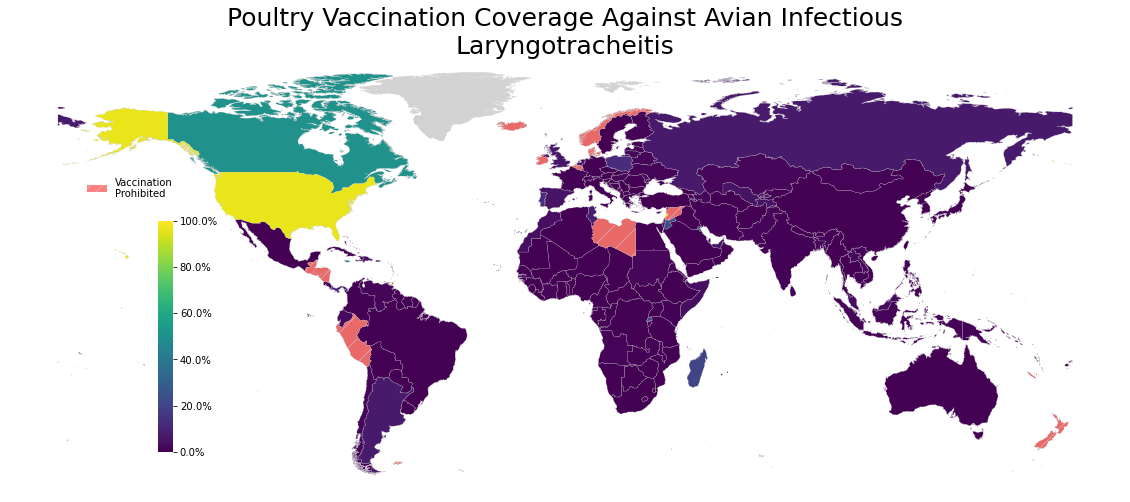

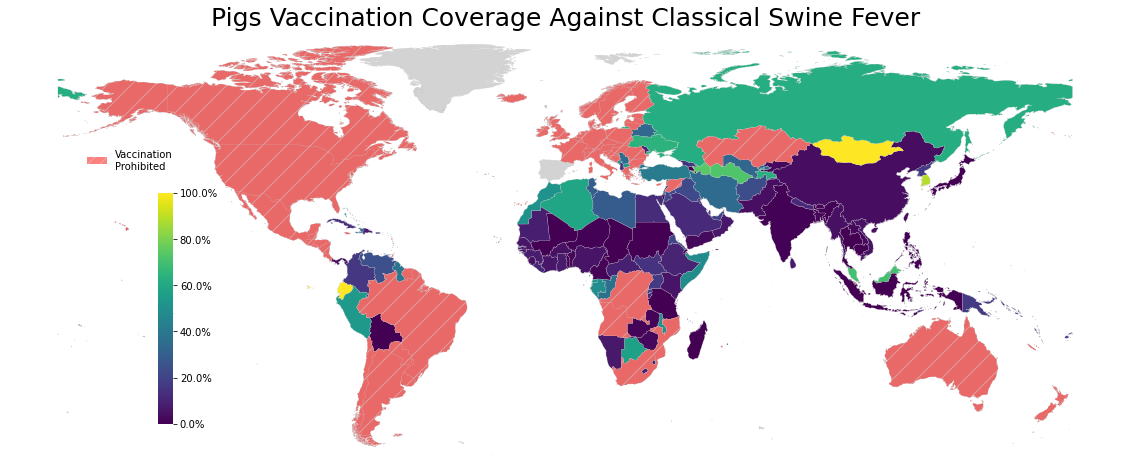

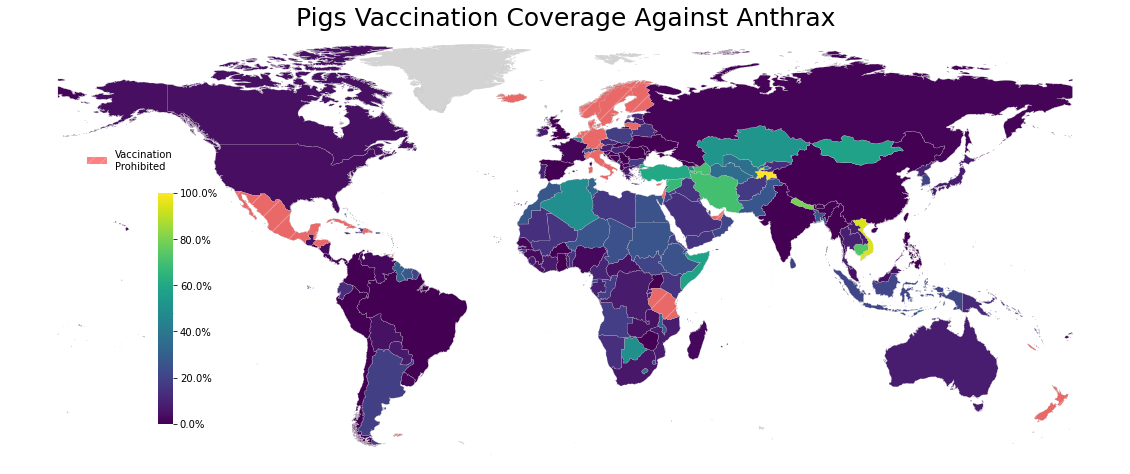

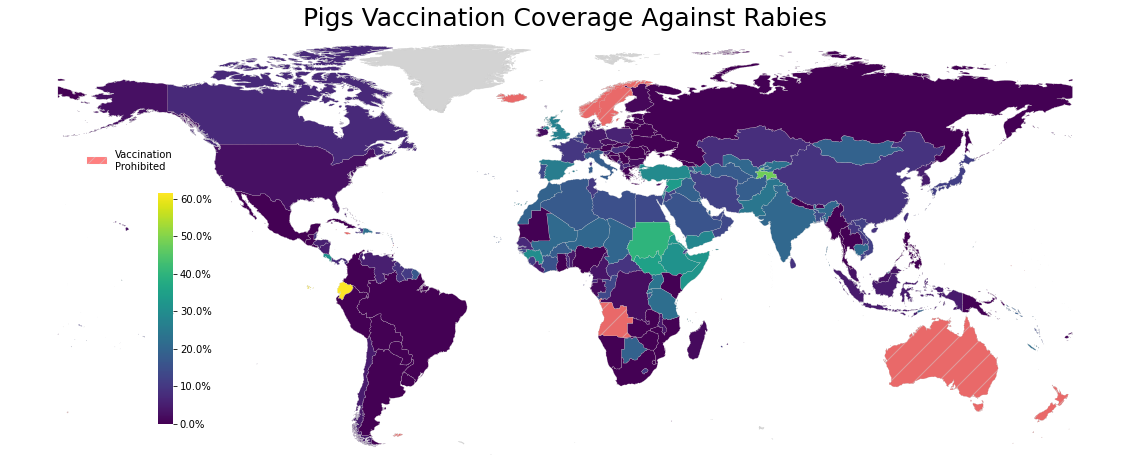

In [27]:
countries_missing_data = dict()
animals=[i[0] for i in top_vaccines]
animals=[i if i!= 'Swine' else 'Pigs' for i in animals]
vaccines=[i[1] for i in top_vaccines]
for animal, disease in zip(animals[0:10]+animals[14:17],vaccines[0:10]+vaccines[14:17]):

    if disease=='Newcastle disease (velogenic)':
        disease='Newcastle disease'
        
    disease_name=disease
    
    if 'virus' in disease_name:
        disease_name=disease_name.replace(' virus','')
    
    if '(Inf. with)' in disease_name:
        disease_name=disease_name.replace(' (Inf. with)','')        
    
    disease_name=re.sub(" [\(\[]-[\d]{4}[\)\]]", "", disease_name)
    
    disease_name=disease_name.title()
    
        
    df_plot=df_animals[(df_animals['Disease']==disease)&(df_animals['Animal']==animal)]
        
    merged_df = pd.merge(right=df_plot,left=geo_df, how='left', left_on='ISO3', right_on='ISO3')
    
    countries_unapproved = df_approved_prohibited[(df_approved_prohibited['Disease']==disease)&(df_approved_prohibited['Animal']==animal)&(df_approved_prohibited['Official Vaccination Measure']=="Vaccination prohibited")]['ISO3'].values
    
    merged_df['Vaccination Coverage (%)']=[vacc if country not in countries_unapproved else None for country,vacc in zip(merged_df['ISO3'],merged_df['Vaccination Coverage (%)'])]
    
    if disease_name == 'Haemorrhagic Septicaemia (Pasteurella Multocida Serotypes 6:B And 6:E)':
        disease_name='Haemorrhagic Septicaemia'
        
    if disease_name == "Marek'S Disease":
        disease_name = "Marek's Disease"
    
    
    title = "\n".join(wrap(animal+" Vaccination Coverage Against "+disease_name, 60))
    col = 'Vaccination Coverage (%)'
    vmin = merged_df[col].min()
    vmax = merged_df[col].max()
    cmap = 'viridis'
    
    fig, ax = plt.subplots(1, figsize=(20, 8))
    
    ax.axis('off')
    ax2 = ax.twinx()
    ax2.axis('off')
    
    legend_elements2 = [mpatches.Patch(label='Vaccination\nProhibited',color='Red',alpha=0.5,hatch='//', ec="lightgrey",
                                      linewidth=0.2)]
    
    merged_df.plot(column=col, norm=Normalize(vmin=vmin,vmax=vmax), ax=ax,edgecolor='0.8', linewidth=.2, cmap=cmap,missing_kwds={'color': 'lightgrey'})
    
    df_copy = merged_df.to_crs('epsg:4326')
    merged_df['area'] = df_copy['geometry'].area / 10**6

    countries_missing_data[animal+'_'+disease_name.title()]=[]
    
    
    prohibiteds=[]


    for row in df_approved_prohibited[(df_approved_prohibited['Disease']==disease)&(df_approved_prohibited['Animal']==animal)].iterrows():
        if row[1]['Official Vaccination Measure']=='Vaccination prohibited':
            try:
                prohibiteds+=[row[1]['ISO3']]
                plotCountryPatch(ax, row[1]['ISO3'], 'red',merged_df)
            except:# Geopandas does not have a shape for this coutry (country may no longer exist)
                pass

    for row in merged_df.iterrows():
        if (row[1]['Vaccination Coverage (%)']!=row[1]['Vaccination Coverage (%)']):
            if (row[1]['ISO3'] not in prohibiteds):
                try:
                    countries_missing_data[animal+'_'+disease_name.title()]+=[(row[1]['ISO3']+': '+iso3_to_country[row[1]['ISO3']],row[1]['area'])]
                except:
                    pass
    
    try:

        if len(prohibiteds)>0:
            ax2.legend(handles=legend_elements2, bbox_to_anchor=(.11,.75),loc="upper center",  fancybox=True, framealpha=0)
            
    except:
        pass

    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
    
    
    color_bar=fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax,cax=fig.add_axes([0.23, 0.2, 0.01, 0.4]))
    color_bar.outline.set_visible(False)
    

        
    disease_name=disease_name.replace('/','')

    color_bar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in color_bar.get_ticks()])

    plt.show()
    
    
    if not os.path.exists('ARCPY Maps/'+animal+'/'):
        os.makedirs('ARCPY Maps/'+animal+'/')
    
    if not os.path.exists('ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/'):
        os.makedirs('ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/')
    
    
    to_feature_class=merged_df.copy()
    to_feature_class = to_feature_class[to_feature_class['Vaccination Coverage (%)'].notna()]
    
    to_feature_class['Vaccination Coverage (%)']/=100
    
    to_feature_class['Unvaccination Coverage']=[1-i for i in to_feature_class['Vaccination Coverage (%)']]
    
    to_feature_class.rename(columns={'Latest population recorded':'latest_pop','country_code':'count_code','Year latest population':'year_pop','Source':'source','Vaccination Coverage (%)':'vacc_cov','Unvaccination Coverage':'unvacc_cov'},inplace=True)
    GeoAccessor.from_geodataframe(to_feature_class, inplace=False, column_name='SHAPE').spatial.to_featureclass(location='ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/feature_class.shp",sanitize_columns=False)

    arcpy.conversion.PolygonToRaster(in_features='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/feature_class.shp', value_field="vacc_cov",out_rasterdataset='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/vacc_coverage',
                                     cell_assignment='CELL_CENTER',cellsize=0.08333333333333333)
    arcpy.conversion.PolygonToRaster(in_features='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/feature_class.shp', value_field="unvacc_cov",out_rasterdataset='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/unvac_cov',
                                     cell_assignment='CELL_CENTER',cellsize=0.08333333333333333)
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/vacc_coverage"
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","number_chickens.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","number_cattle.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","number_pigs.tif")
    
    # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/unscaled_vaccinated.tif")
    arcpy.conversion.PolygonToRaster(in_features='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/feature_class.shp', value_field="scale",out_rasterdataset='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/scale',
                                     cell_assignment='CELL_CENTER',cellsize=0.08333333333333333)
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/unscaled_vaccinated.tif"
    inConstant ='ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scale"
    
    # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_vaccinated.tif")
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_vaccinated.tif"
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","Area10km.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","Area10km.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","Area10km.tif")
    
    
    # Execute Divide
    outDivide = arcpy.sa.Divide(inRaster, inConstant)
    outDivide.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_area_vaccinated.tif")
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_area_vaccinated.tif"
    inConstant =1
    
    # Execute Plus
    outPlus = arcpy.sa.Plus(inRaster, inConstant)
    outPlus.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_vaccinated_plus1.tif")
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_vaccinated_plus1.tif"
    
    # Execute Log10
    outLog10 = arcpy.sa.Log10(inRaster)
    
    # Save the output 
    outLog10.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_vaccinated_plus1_log10.tif")
    
    #Now for unvaccinated!:
    
 # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/unvac_cov"
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","number_chickens.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","number_cattle.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","number_pigs.tif")
    
    # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/unscaled_unvaccinated.tif")
    
    arcpy.conversion.PolygonToRaster(in_features='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/feature_class.shp', value_field="scale",out_rasterdataset='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/scale',
                                     cell_assignment='CELL_CENTER',cellsize=0.08333333333333333)
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/unscaled_unvaccinated.tif"
    inConstant ='ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scale"
    
    # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_unvaccinated.tif")
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_unvaccinated.tif"
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","Area10km.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","Area10km.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","Area10km.tif")
    
    
    # Execute Divide
    outDivide = arcpy.sa.Divide(inRaster, inConstant)
    outDivide.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_area_unvaccinated.tif")
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_area_unvaccinated.tif"
    inConstant =1
    
    # Execute Plus
    outPlus = arcpy.sa.Plus(inRaster, inConstant)
    outPlus.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_unvaccinated_plus1.tif")
    
    
    # Set local variables
    inRaster = 'ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_unvaccinated_plus1.tif"
    
    # Execute Log10
    outLog10 = arcpy.sa.Log10(inRaster)
    
    # Save the output 
    outLog10.save('ARCPY Maps/'+animal+'/'+disease_name+"_area_adjusted/scaled_unvaccinated_plus1_log10.tif")
    
    if len(prohibiteds)>0:
        GeoAccessor.from_geodataframe(merged_df[merged_df['ISO3'].isin(prohibiteds)].loc[:,['ISO3','geometry']],inplace=False,column_name='SHAPE').spatial.to_featureclass(location='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/vaccination_prohibited.shp',sanitize_columns=False)
    GeoAccessor.from_geodataframe(merged_df[(merged_df['Source']=='Imputed')&(~merged_df['ISO3'].isin(prohibiteds))&(merged_df['ISO3']!='GRL')],inplace=False,column_name='SHAPE').spatial.to_featureclass(location='ARCPY Maps/'+animal+'/'+disease_name+'_area_adjusted/imputeds.shp',sanitize_columns=False)
    
for key in countries_missing_data.keys():
    countries_missing_data[key]=sorted(countries_missing_data[key], key=lambda x: x[1],reverse=True)
    countries_missing_data[key]=[i[0] for i in countries_missing_data[key]]
    
for key in countries_missing_data.keys():
    while len(countries_missing_data[key])<max([len(i) for i in countries_missing_data.values()]):
        countries_missing_data[key]+=[None]
    
        
#pd.DataFrame.from_dict(countries_missing_data).to_csv('Countries with mising data, by disease.csv',index=False)